# Final Project: Face Mask Detection
## Load data

In [1]:
import os
import keras
import numpy as np
import tensorflow as tf

In [2]:
NEW_TRAINING = False
TRAIN_DIR = '../input/face-mask-detection/datasets/precessed@v2'
BATCH_SIZE = 64
EPOCHS = 20
TARGET_SIZE = [300, 400]# [168, 224] # 3:4
BASEMODEL_PATH = 'models/base_model.h5'
BESTMODEL_PATH = 'models/best_model.h5'

PROJECT_ROOT_DIR = "."
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODELS_PATH, exist_ok=True)

In [3]:
# Get list subfolder
list_subfolder = os.listdir(TRAIN_DIR)
print('All labels : ', list_subfolder)

All labels :  ['not_mask', 'correct_mask', 'incorrect_mask']


In [4]:
import pandas as pd

# Random split data
CREATE_NEW_SET = False
LABELS = []
IMAGES = []
for subfolder in list_subfolder:
    sunfolder_path = os.path.join(TRAIN_DIR, subfolder)
    for file_name in os.listdir(sunfolder_path):
        file_path = os.path.join(subfolder, file_name)
        IMAGES.append(file_path)
        LABELS.append(subfolder)
df_train = pd.DataFrame({
    'image': IMAGES,
    'label': LABELS
})
df_train.head()

,image,label
0,not_mask/04168.jpg,not_mask
1,not_mask/02371.jpg,not_mask
2,not_mask/04377.jpg,not_mask
3,not_mask/00767.jpg,not_mask
4,not_mask/02360.jpg,not_mask


In [5]:
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)

df_train_set, df_val_set = train_test_split(df_train, test_size=0.2, random_state=42)
df_train_set.to_csv('df_train_set.csv')
df_val_set.to_csv('df_val_set.csv')

## Data Augmentation
### train_set with ImageDataGenerator

In [6]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   zoom_range=0.1, 
                                   horizontal_flip=True, 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')
train_set = train_datagen.flow_from_dataframe(dataframe=df_train_set,
                                              directory=TRAIN_DIR,
                                              x_col="image",
                                              y_col="label",
                                              shuffle=True,
                                              class_mode="sparse",
                                              batch_size=BATCH_SIZE,
                                              target_size=TARGET_SIZE)

Found 11732 validated image filenames belonging to 3 classes.


### Show demo Data Augmentation

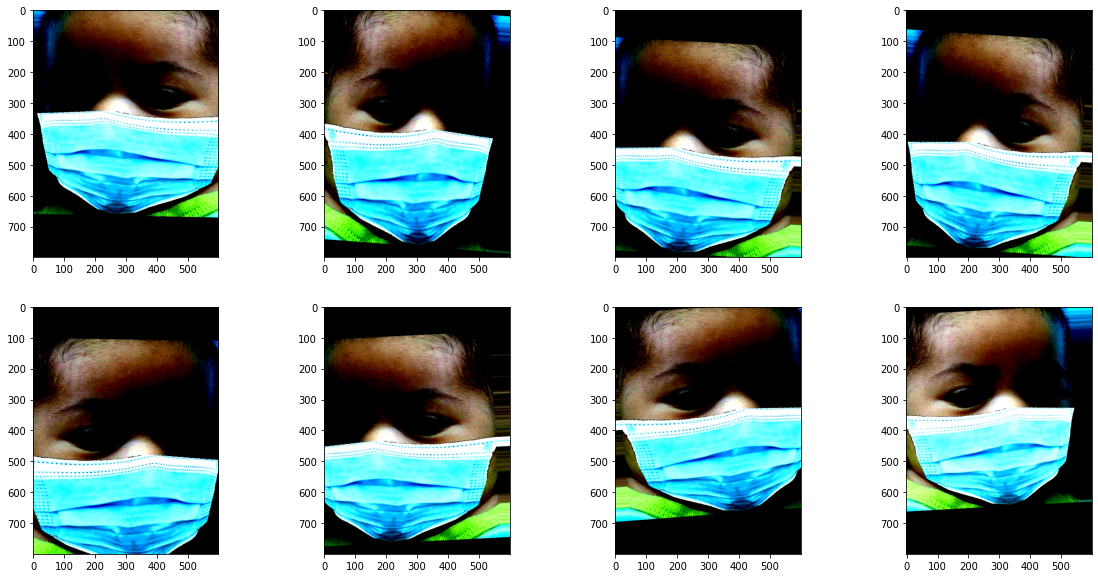

In [7]:
img = load_img("../input/face-mask-detection/datasets/processed/correct_mask/00000_Mask.jpg")
example_aug = img_to_array(img)/255.
example_aug = example_aug[np.newaxis]
plt.figure(figsize=(20,10))
for i,img in enumerate(train_datagen.flow(example_aug, batch_size=1)):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.squeeze(img))
    if i == 7:
        break
plt.show()

### train_set with ImageDataGenerator

In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_dataframe(dataframe=df_val_set,
                                          directory=TRAIN_DIR,
                                          x_col="image",
                                          y_col="label",
                                          class_mode="sparse", 
                                          batch_size=BATCH_SIZE,
                                          target_size=TARGET_SIZE)

Found 2933 validated image filenames belonging to 3 classes.


## Build model

In [9]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout, MaxPooling2D
from keras.models import Sequential

tf.random.set_seed(42)
np.random.seed(42)

# build model
def define_model():
    base_model = MobileNetV2(weights="imagenet", 
                             include_top=False, 
                             input_tensor=Input(shape=(300, 400, 3)))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        AveragePooling2D(pool_size=(7, 7)),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dropout(0.2),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    return model

model = define_model()
model.summary()
model.save(BASEMODEL_PATH)

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 13, 1280)      2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
___________________________________________________________

In [10]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-4, max_rate=0.2):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
    init_weights = model.get_weights()
    iterations = math.ceil(len(X)) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, validation_data=y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.figure(figsize=(16,8))
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses))])
    
    good_loss = [rates[losses.index(min(losses))], min(losses)]
    plt.plot(good_loss[0], good_loss[1], 'go')
    plt.text(good_loss[0], good_loss[1]+10**-2, 
             "Good Loss: (lr = {})".format(good_loss[0]), fontsize=12)
    
    bad_index_lastest = losses.index(min(losses))
    for index in range(losses.index(min(losses))+1, losses.index(min(losses))+20):
        if losses[index] > losses[bad_index_lastest]:
            bad_index_lastest = index
        else: break
    bad_loss_lastest = [rates[bad_index_lastest], losses[bad_index_lastest]]
    plt.plot(bad_loss_lastest[0], bad_loss_lastest[1], 'ro')
    plt.text(bad_loss_lastest[0], bad_loss_lastest[1]+10**-2, 
             "Bad Loss Lastest: (lr = {})".format(bad_loss_lastest[0]), fontsize=12)
    
    good_lr = bad_loss_lastest[0]
    
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    return good_lr

184/184 [==============================] - 515s 3s/step - loss: 1.0629 - accuracy: 0.6217 - val_loss: 1.0982 - val_accuracy: 0.3481
Good learning rate: 0.0016593782929703593


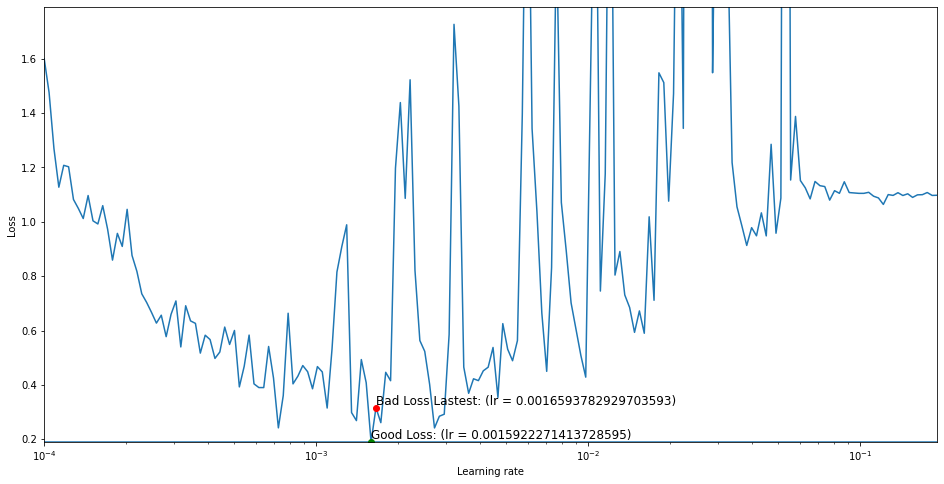

In [11]:
from keras.models import load_model

tf.random.set_seed(42)
np.random.seed(42)

model = load_model(BASEMODEL_PATH)
batch_size = BATCH_SIZE
rates, losses = find_learning_rate(model, train_set, val_set, epochs=1, batch_size=batch_size)
good_lr = plot_lr_vs_loss(rates, losses)
print('Good learning rate: {}'.format(good_lr))

## Training model

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Nadam

tf.random.set_seed(42)
np.random.seed(42)

model = load_model(BASEMODEL_PATH)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=good_lr), 
              metrics=["accuracy"])

print(model.optimizer.lr)

modelCheckpoint = ModelCheckpoint(
    BESTMODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
)
earlyStopping = EarlyStopping(
    monitor="accuracy",
    patience=3,
    restore_best_weights=True,
)
history = model.fit(train_set, 
                    validation_data=val_set,
                    epochs=EPOCHS,
                    callbacks=[modelCheckpoint, earlyStopping])

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0016593783>
Epoch 1/20
184/184 [==============================] - 472s 3s/step - loss: 0.5323 - accuracy: 0.7881 - val_loss: 0.7250 - val_accuracy: 0.7341
Epoch 2/20
184/184 [==============================] - 459s 2s/step - loss: 0.1752 - accuracy: 0.9342 - val_loss: 0.8791 - val_accuracy: 0.6897
Epoch 3/20
184/184 [==============================] - 458s 2s/step - loss: 0.1585 - accuracy: 0.9418 - val_loss: 0.2626 - val_accuracy: 0.8970
Epoch 4/20
184/184 [==============================] - 449s 2s/step - loss: 0.1372 - accuracy: 0.9484 - val_loss: 0.5532 - val_accuracy: 0.8040
Epoch 5/20
184/184 [==============================] - 448s 2s/step - loss: 0.1334 - accuracy: 0.9500 - val_loss: 0.6079 - val_accuracy: 0.7961
Epoch 6/20
184/184 [==============================] - 451s 2s/step - loss: 0.1141 - accuracy: 0.9576 - val_loss: 0.4348 - val_accuracy: 0.8360
Epoch 7/20
184/184 [==============================] - 451s 2s/step 

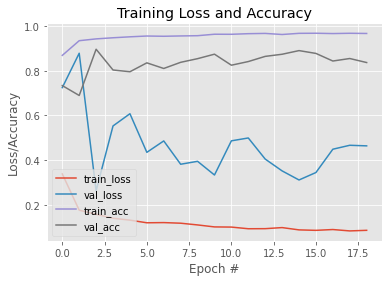

In [13]:
history = history.history
epochs_ = len(history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs_), history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_), history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs_), history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs_), history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])